LOAD REQUIRED PACKAGES

In [1]:
#required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error



IMPORT DATASET

In [2]:
#import the dataset (various sheets from the dataset)
Customer_Demographics = pd.read_excel("Customer_Churn_Data_Large.xlsx", sheet_name = "Customer_Demographics")
transaction_history = pd.read_excel("Customer_Churn_Data_Large.xlsx", sheet_name = "Transaction_History")
customer_service = pd.read_excel("Customer_Churn_Data_Large.xlsx", sheet_name = "Customer_Service")
Online_Activity = pd.read_excel("Customer_Churn_Data_Large.xlsx", sheet_name = "Online_Activity")
Churn_Status = pd.read_excel("Customer_Churn_Data_Large.xlsx", sheet_name = "Churn_Status")

AGGREGATE AND MERGE THE VARIOUS SHEETS

In [3]:
transaction_summary = transaction_history.groupby('CustomerID').agg(  #aggregate transaction history per customer
    total_transactions = ('TransactionID', 'count'), 
    total_spent = ('AmountSpent', 'sum'),
    avg_spend = ('AmountSpent', 'mean'),
    unique_categories = ('ProductCategory', 'nunique')
).reset_index()

merged_data = pd.merge(Customer_Demographics, transaction_summary, on = 'CustomerID', how = 'left') #merge with cutomer demographics

merged_data = pd.merge(Churn_Status, merged_data, on = 'CustomerID', how = 'left') #merge with churn status

merged_data = pd.merge(merged_data, Online_Activity, on = 'CustomerID', how = 'left') #merge with online activity


service_summary = customer_service.groupby('CustomerID').agg(    #aggregate customer service interactions
    unresolved_issues = ('ResolutionStatus', lambda x: (x == 'Unresolved').sum()),
    total_interactions = ('InteractionID', 'count')
).reset_index()

merged_data = pd.merge(merged_data, service_summary, on = 'CustomerID', how = 'left') #merge with service summary

merged_data.head(10)

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,ServiceUsage,unresolved_issues,total_interactions
0,1,0,62,M,Single,Low,1,416.50,416.500000,1,2023-10-21,34,Mobile App,0.0,1.0
1,2,1,65,M,Married,Low,7,1547.42,221.060000,4,2023-12-05,5,Website,0.0,1.0
2,3,0,18,M,Single,Low,6,1702.98,283.830000,4,2023-11-15,3,Website,0.0,1.0
3,4,0,21,M,Widowed,Low,5,917.29,183.458000,4,2023-08-25,2,Website,1.0,2.0
4,5,0,21,M,Divorced,Medium,8,2001.49,250.186250,3,2023-10-27,41,Website,NaN,NaN
5,6,0,57,F,Divorced,Medium,5,1164.29,232.858000,4,2023-09-17,2,Website,0.0,1.0
6,7,0,27,F,Married,High,1,86.73,86.730000,1,2023-01-07,32,Mobile App,NaN,NaN
7,8,1,37,M,Single,Low,7,2046.88,292.411429,4,2023-04-22,17,Online Banking,2.0,2.0
8,9,0,39,M,Divorced,High,5,1317.24,263.448000,3,2023-06-27,24,Website,0.0,1.0
9,10,1,68,M,Married,High,7,1397.36,199.622857,4,2023-01-13,29,Online Banking,NaN,NaN


CHECK DATATYPES

In [4]:
merged_data.dtypes

CustomerID                     int64
ChurnStatus                    int64
Age                            int64
Gender                        object
MaritalStatus                 object
IncomeLevel                   object
total_transactions             int64
total_spent                  float64
avg_spend                    float64
unique_categories              int64
LastLoginDate         datetime64[ns]
LoginFrequency                 int64
ServiceUsage                  object
unresolved_issues            float64
total_interactions           float64
dtype: object

CHECK AND HANDLE MISSING VALUES

In [5]:
merged_data.isnull().sum()  #check for missing values

CustomerID              0
ChurnStatus             0
Age                     0
Gender                  0
MaritalStatus           0
IncomeLevel             0
total_transactions      0
total_spent             0
avg_spend               0
unique_categories       0
LastLoginDate           0
LoginFrequency          0
ServiceUsage            0
unresolved_issues     332
total_interactions    332
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

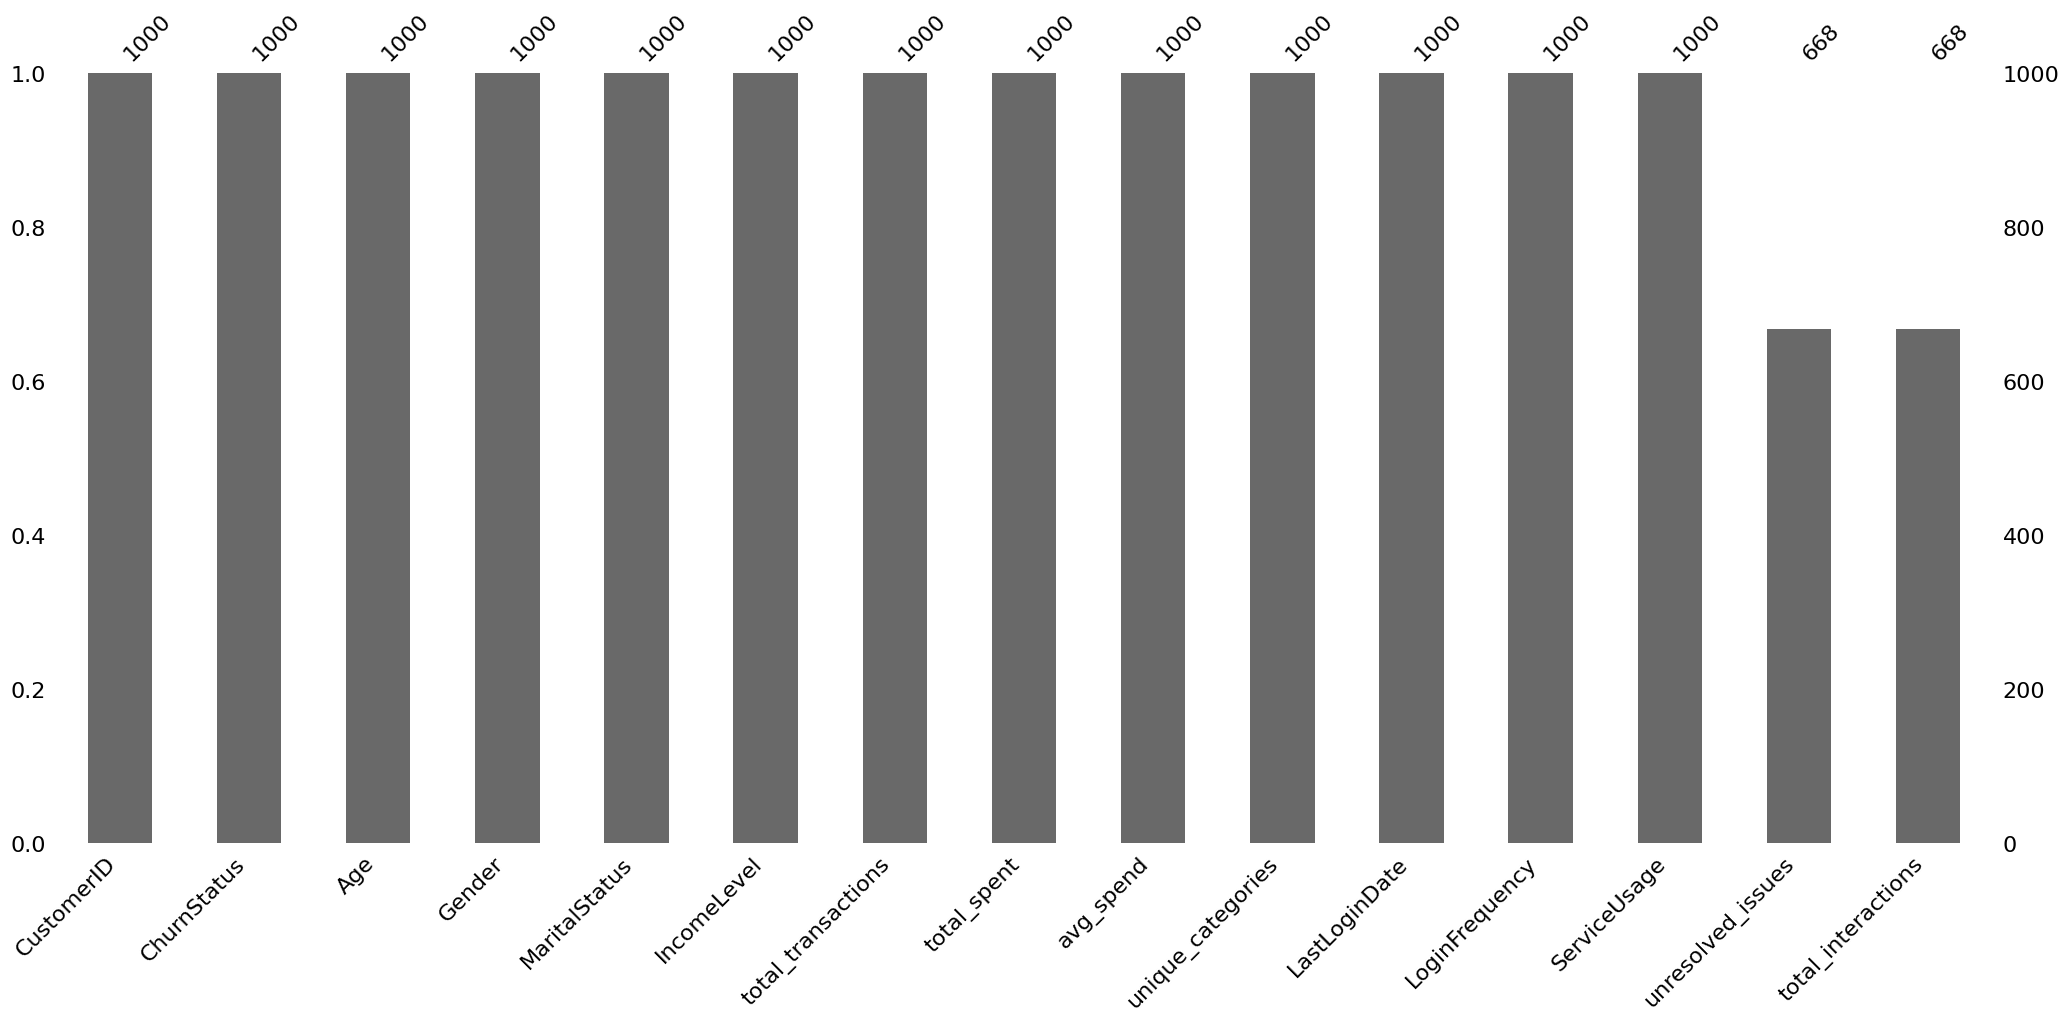

In [6]:
#visualise missing values
import missingno as msno

# msno.matrix(merged_data)
msno.bar(merged_data)
plt.show

In [7]:
#handle missing values by filling with 0
merged_data['unresolved_issues'] = merged_data['unresolved_issues'].fillna(0) 
merged_data['total_interactions'] = merged_data['total_interactions'].fillna(0)
merged_data.head(10)

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,ServiceUsage,unresolved_issues,total_interactions
0,1,0,62,M,Single,Low,1,416.50,416.500000,1,2023-10-21,34,Mobile App,0.0,1.0
1,2,1,65,M,Married,Low,7,1547.42,221.060000,4,2023-12-05,5,Website,0.0,1.0
2,3,0,18,M,Single,Low,6,1702.98,283.830000,4,2023-11-15,3,Website,0.0,1.0
3,4,0,21,M,Widowed,Low,5,917.29,183.458000,4,2023-08-25,2,Website,1.0,2.0
4,5,0,21,M,Divorced,Medium,8,2001.49,250.186250,3,2023-10-27,41,Website,0.0,0.0
5,6,0,57,F,Divorced,Medium,5,1164.29,232.858000,4,2023-09-17,2,Website,0.0,1.0
6,7,0,27,F,Married,High,1,86.73,86.730000,1,2023-01-07,32,Mobile App,0.0,0.0
7,8,1,37,M,Single,Low,7,2046.88,292.411429,4,2023-04-22,17,Online Banking,2.0,2.0
8,9,0,39,M,Divorced,High,5,1317.24,263.448000,3,2023-06-27,24,Website,0.0,1.0
9,10,1,68,M,Married,High,7,1397.36,199.622857,4,2023-01-13,29,Online Banking,0.0,0.0


In [8]:
#recheck missing values
merged_data.isnull().sum()

CustomerID            0
ChurnStatus           0
Age                   0
Gender                0
MaritalStatus         0
IncomeLevel           0
total_transactions    0
total_spent           0
avg_spend             0
unique_categories     0
LastLoginDate         0
LoginFrequency        0
ServiceUsage          0
unresolved_issues     0
total_interactions    0
dtype: int64

CHECK FOR DUPLICATES

In [9]:
#check for duplicates
duplicate = merged_data.duplicated().sum()
duplicate

np.int64(0)

FEATURE ENGINEERING

In [10]:
merged_data['LastLoginDate'] = pd.to_datetime(merged_data['LastLoginDate']) #convert to date format
current_date = pd.to_datetime('2025-06-06')

merged_data['days_since_last_login'] = (current_date - merged_data['LastLoginDate']).dt.days   #number of days since last login
merged_data['days_since_last_login'] = merged_data['days_since_last_login'].fillna(999)  #no login yet

merged_data.head(10)

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,ServiceUsage,unresolved_issues,total_interactions,days_since_last_login
0,1,0,62,M,Single,Low,1,416.50,416.500000,1,2023-10-21,34,Mobile App,0.0,1.0,594
1,2,1,65,M,Married,Low,7,1547.42,221.060000,4,2023-12-05,5,Website,0.0,1.0,549
2,3,0,18,M,Single,Low,6,1702.98,283.830000,4,2023-11-15,3,Website,0.0,1.0,569
3,4,0,21,M,Widowed,Low,5,917.29,183.458000,4,2023-08-25,2,Website,1.0,2.0,651
4,5,0,21,M,Divorced,Medium,8,2001.49,250.186250,3,2023-10-27,41,Website,0.0,0.0,588
5,6,0,57,F,Divorced,Medium,5,1164.29,232.858000,4,2023-09-17,2,Website,0.0,1.0,628
6,7,0,27,F,Married,High,1,86.73,86.730000,1,2023-01-07,32,Mobile App,0.0,0.0,881
7,8,1,37,M,Single,Low,7,2046.88,292.411429,4,2023-04-22,17,Online Banking,2.0,2.0,776
8,9,0,39,M,Divorced,High,5,1317.24,263.448000,3,2023-06-27,24,Website,0.0,1.0,710
9,10,1,68,M,Married,High,7,1397.36,199.622857,4,2023-01-13,29,Online Banking,0.0,0.0,875


In [11]:
merged_data['days_since_last_login'].describe()

count    1000.000000
mean      701.105000
std       104.897299
min       523.000000
25%       613.750000
50%       696.500000
75%       790.000000
max       887.000000
Name: days_since_last_login, dtype: float64

EXPLORATORY DATA ANALYSIS

C:\Users\Admin\AppData\Local\Temp\ipykernel_20288\1133357937.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Retained', 'Churned'])


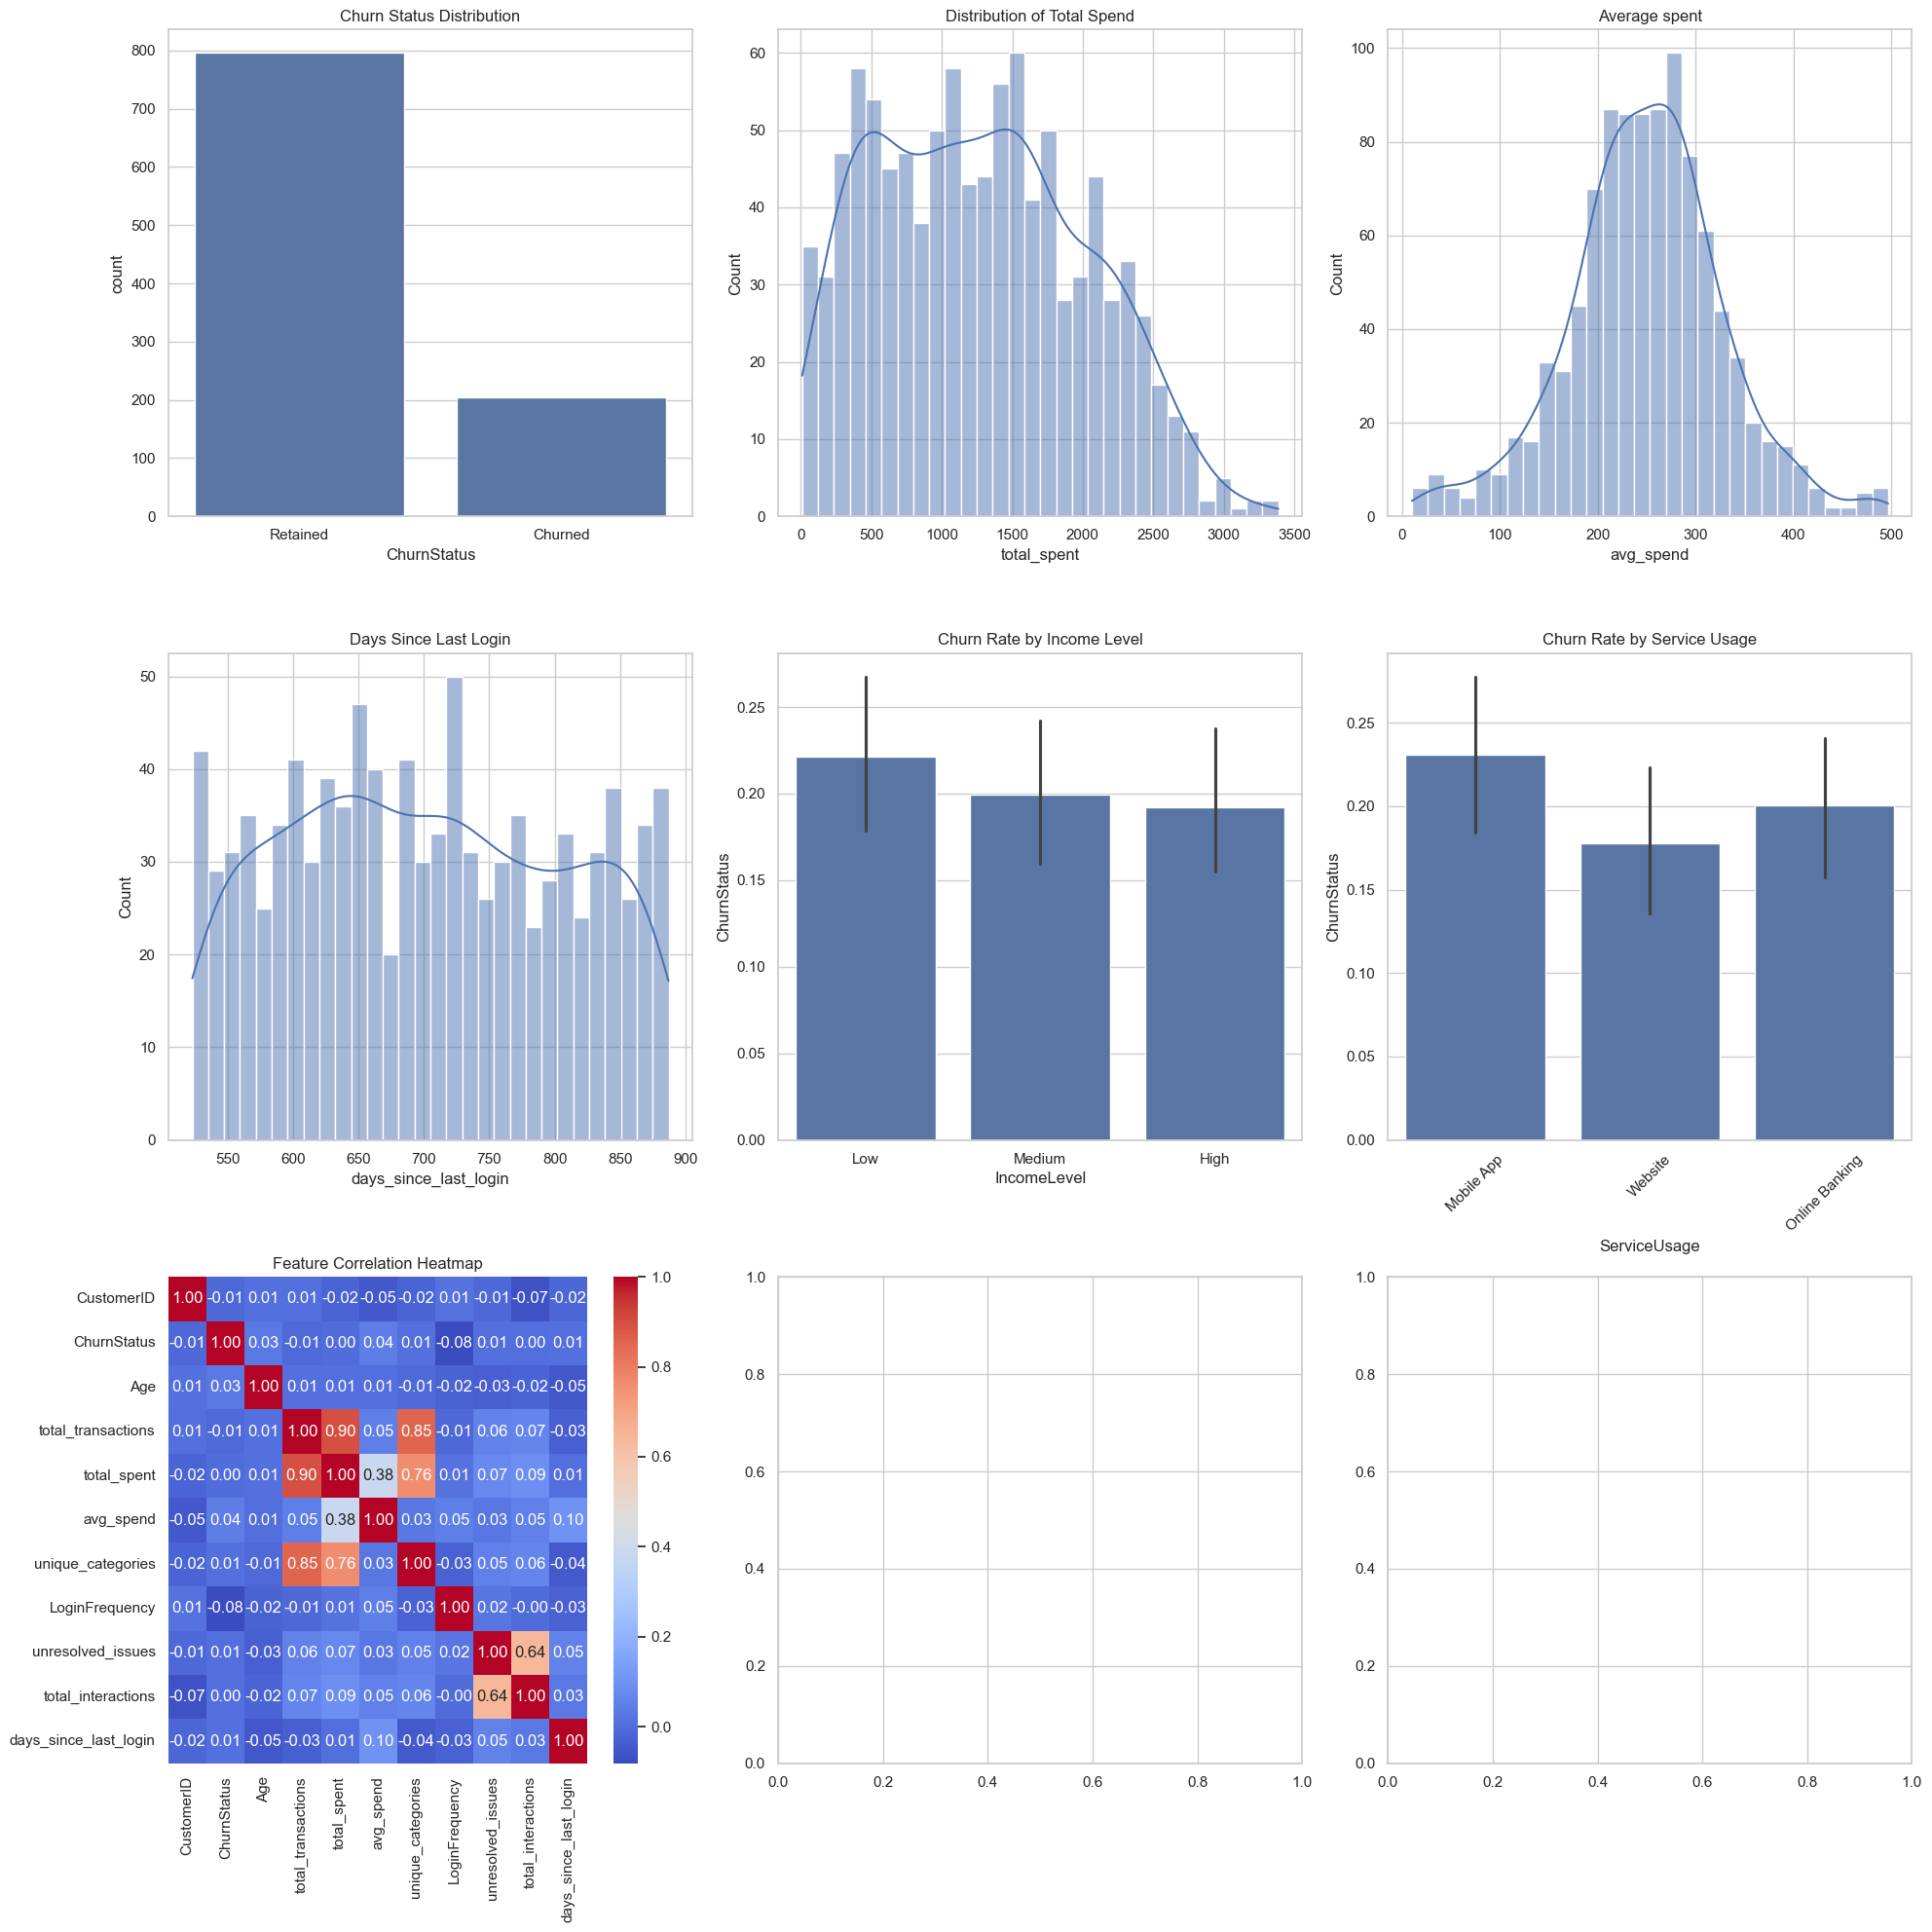

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

#Churn distribution
sns.countplot(data=merged_data, x='ChurnStatus', ax=axes[0, 0])
axes[0, 0].set_title('Churn Status Distribution')
axes[0, 0].set_xticklabels(['Retained', 'Churned'])

#Histogram of total_spent
sns.histplot(merged_data['total_spent'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Total Spend')

#Histogram of days_since_last_login
sns.histplot(merged_data['days_since_last_login'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Days Since Last Login')

#Histogram of average spent
sns.histplot(data=merged_data, x= 'avg_spend', bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Average spent')

#Churn rate by Income Level
sns.barplot(data=merged_data, x='IncomeLevel', y='ChurnStatus', ax=axes[1, 1])
axes[1, 1].set_title('Churn Rate by Income Level')

#Churn rate by Service Usage
sns.barplot(data=merged_data, x='ServiceUsage', y='ChurnStatus', ax=axes[1, 2])
axes[1, 2].set_title('Churn Rate by Service Usage')
axes[1, 2].tick_params(axis='x', rotation=45)


#Correlation heatmap
numeric_cols = merged_data.select_dtypes(include='number')
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2, 0])
axes[2, 0].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

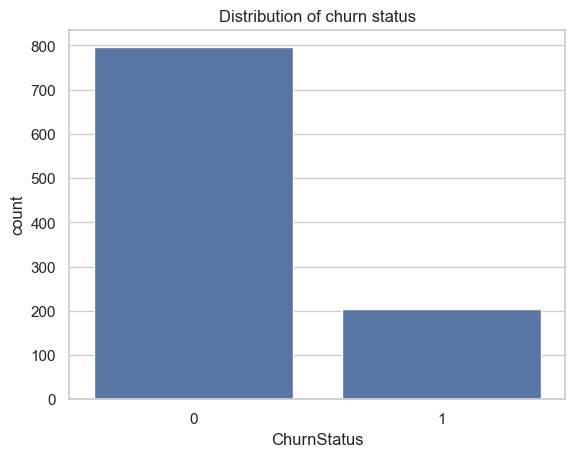

In [13]:
#Distribution of churn status
sns.countplot(data = merged_data, x = 'ChurnStatus')
plt.title('Distribution of churn status')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

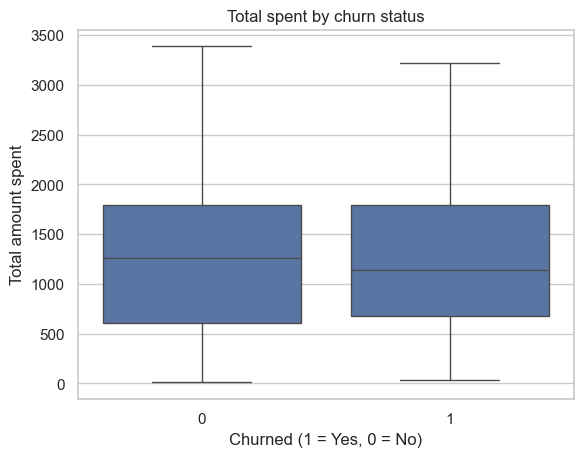

In [14]:
#total spent vs churn

sns.boxplot(data=merged_data, x='ChurnStatus', y='total_spent')
plt.title('Total spent by churn status')
plt.ylabel('Total amount spent')
plt.xlabel('Churned (1 = Yes, 0 = No)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

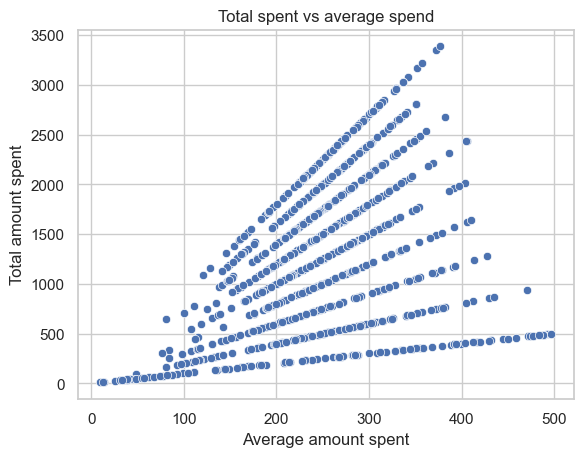

In [15]:
#total spent vs average spent

sns.scatterplot(data=merged_data, x='avg_spend', y='total_spent')
plt.title('Total spent vs average spend')
plt.ylabel('Total amount spent')
plt.xlabel('Average amount spent')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

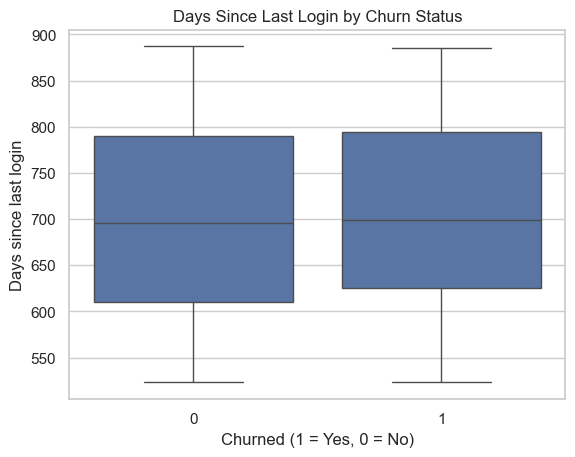

In [16]:
#days since last login vs churn
sns.boxplot(data=merged_data, x='ChurnStatus', y='days_since_last_login')
plt.title('Days Since Last Login by Churn Status')
plt.ylabel('Days since last login')
plt.xlabel('Churned (1 = Yes, 0 = No)')
plt.show

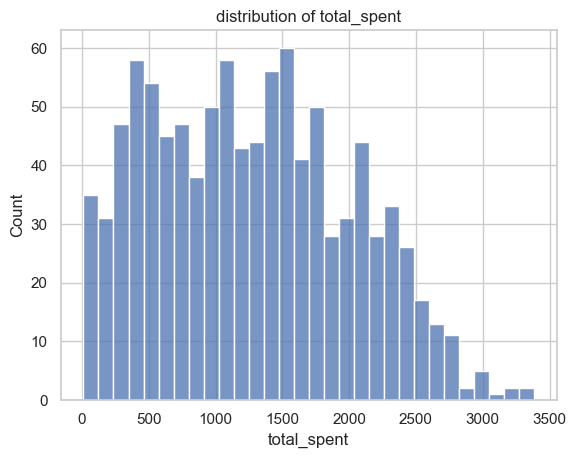

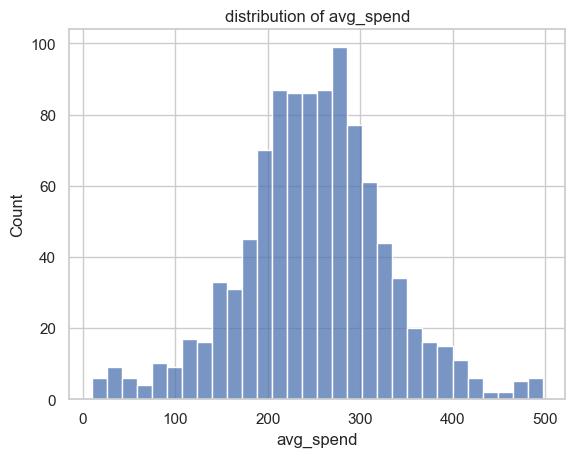

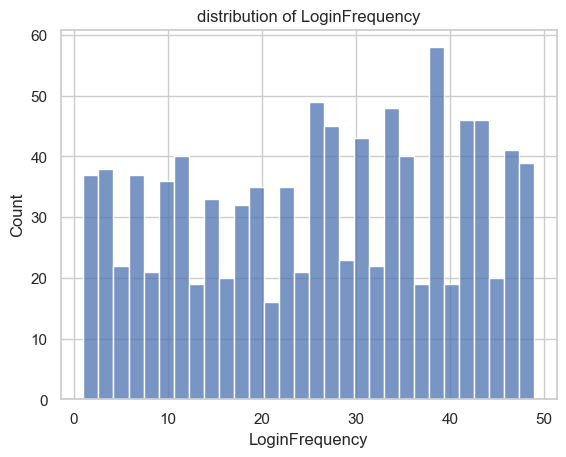

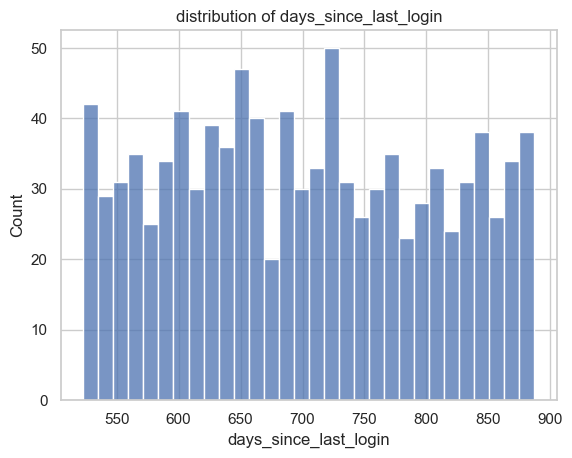

In [17]:
# #distribution of average spent
# sns.histplot(data=merged_data, x='avg_spend')
# plt.title('distribution of average spent')
# plt.xlabel('average spent')
# plt.show



# List the numeric columns you want to inspect
num_cols = [
    'total_spent', 'avg_spend', 'LoginFrequency', 'days_since_last_login'
]

for col in num_cols:
    # plt.figure(figsize=(6, 4))
    sns.histplot(data=merged_data, x=col, bins=30)
    # merged_data.boxplot(column=col)
    plt.title(f"distribution of {col}")
    # plt.tigh_layout()
    plt.show()

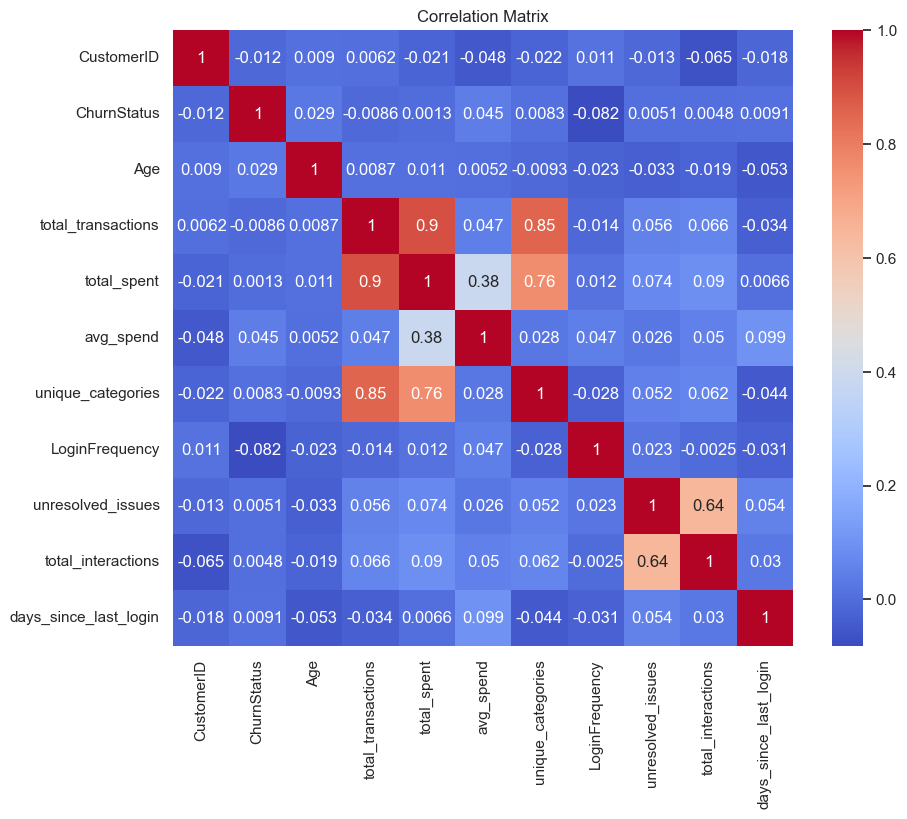

In [18]:
#correlation heatmap
numeric_cols = merged_data.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

CHECK FOR OUTLIERS

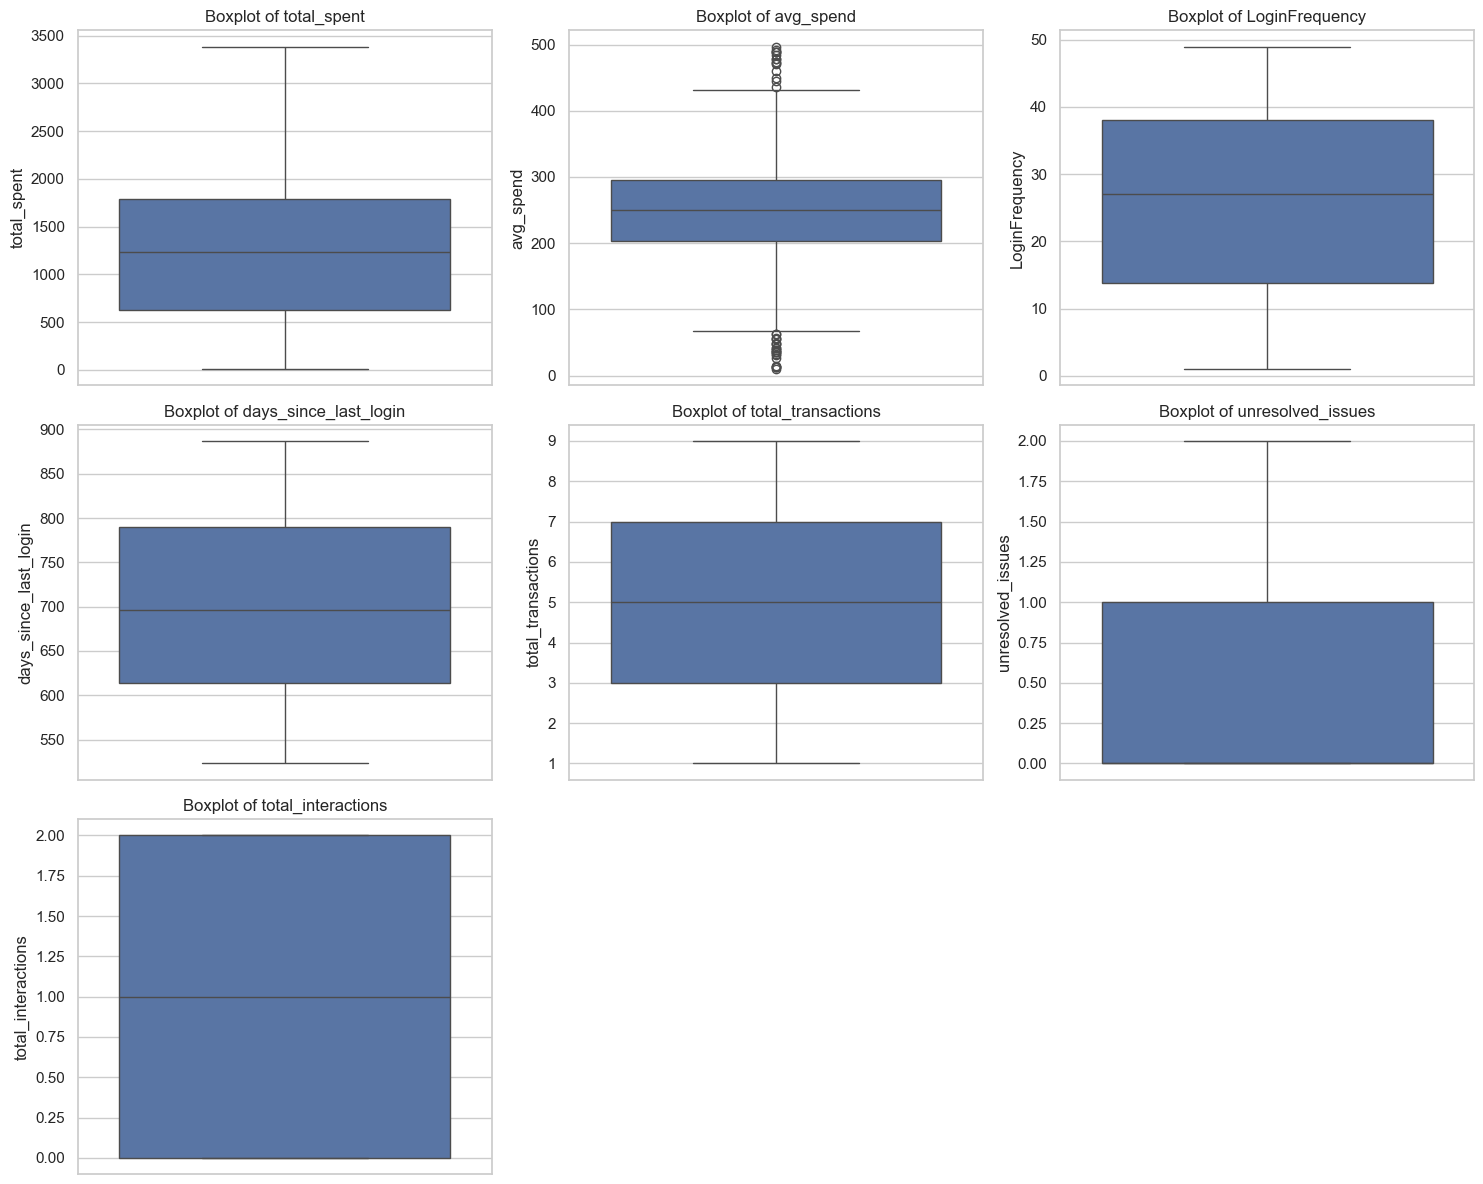

,Outlier Count
total_spent,0
avg_spend,38
LoginFrequency,0
days_since_last_login,0
total_transactions,0
unresolved_issues,0
total_interactions,0


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns to check
num_cols = ['total_spent', 'avg_spend', 'LoginFrequency', 'days_since_last_login', 
            'total_transactions', 'unresolved_issues', 'total_interactions']

# 1. Boxplots for visual outlier detection
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=merged_data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# 2. IQR-based outlier detection
outlier_summary = {}
for col in num_cols:
    Q1 = merged_data[col].quantile(0.25)
    Q3 = merged_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = merged_data[(merged_data[col] < lower_bound) | (merged_data[col] > upper_bound)]
    outlier_summary[col] = outliers.shape[0]

# Display number of outliers per column
pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])


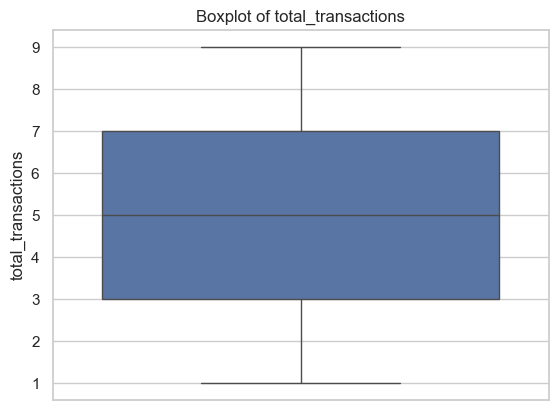

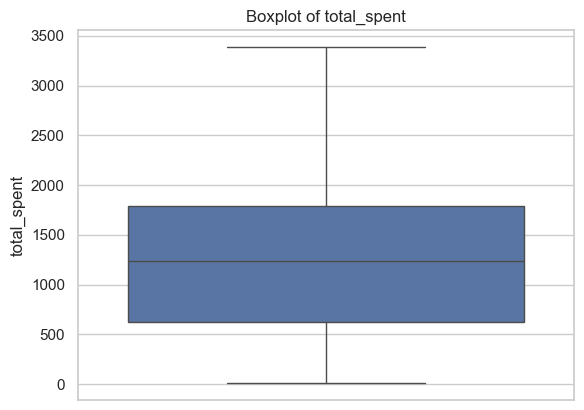

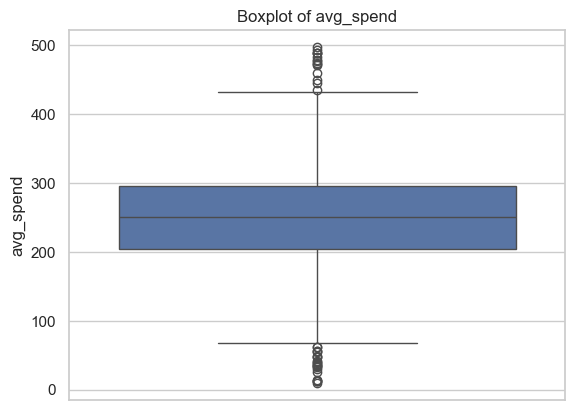

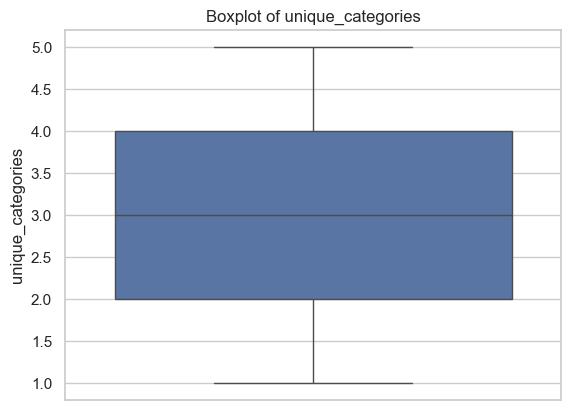

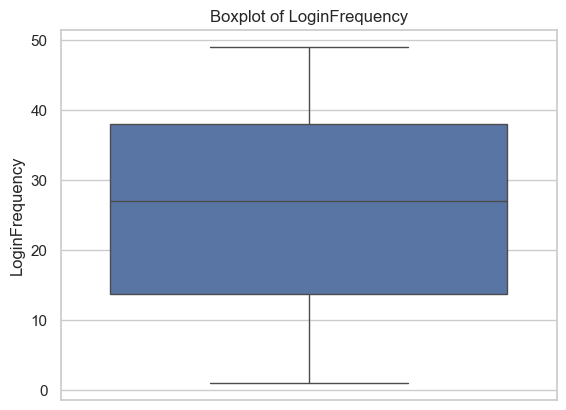

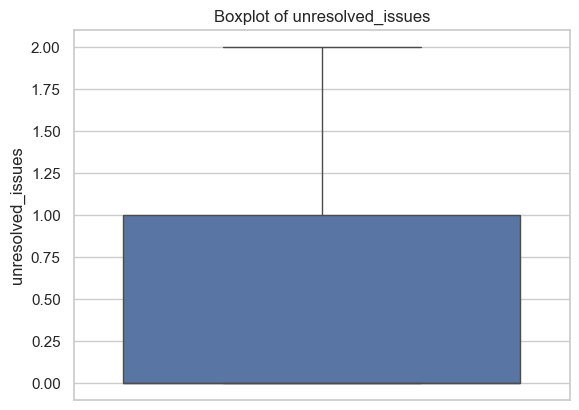

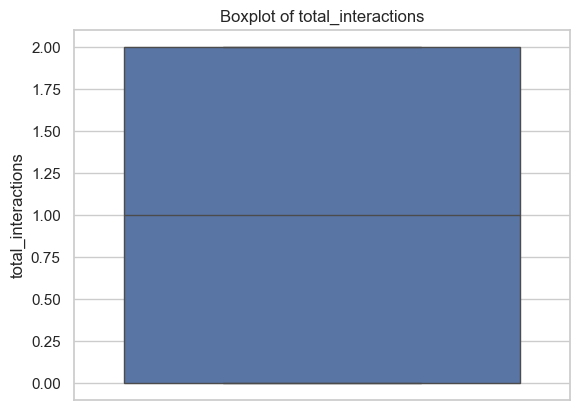

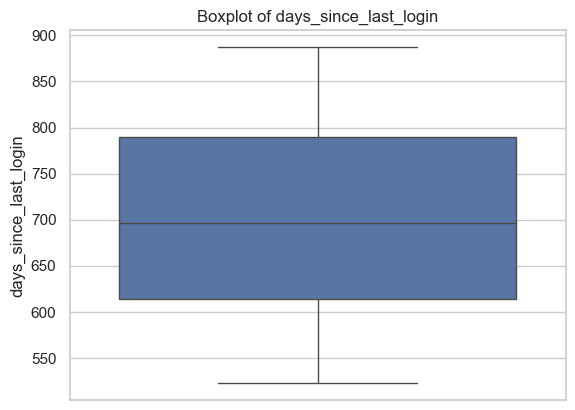

In [20]:
num_cols = [
    'total_transactions', 'total_spent', 'avg_spend',
    'unique_categories', 'LoginFrequency', 'unresolved_issues',
    'total_interactions', 'days_since_last_login'
]

for col in num_cols:
    # plt.figure(figsize=(6, 4))
    sns.boxplot(data=merged_data, y=col)
    # merged_data.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    # plt.tight_layout()
    plt.show()


ENCODE CATEGORICAL FEATURE

In [44]:
#Select all categorical columns
cat_cols = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()

#remove date columns from encoding if present
cat_cols = [col for col in cat_cols if col != 'LastLoginDate']

#Apply one-hot encoding to all categorical variables
df_encoded = pd.get_dummies(merged_data, columns=cat_cols, drop_first=False)

#Convert only applicable columns to int (object columns are now dummy-encoded)
# Skip datetime conversion and already numeric columns
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

#Reconvert date column if needed
df_encoded['LastLoginDate'] = pd.to_datetime(df_encoded['LastLoginDate'])


In [45]:
df_encoded

,CustomerID,ChurnStatus,Age,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,unresolved_issues,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_High,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,0,62,1,416.50,416.500000,1,2023-10-21,34,0.0,...,0,0,1,0,0,1,0,1,0,0
1,2,1,65,7,1547.42,221.060000,4,2023-12-05,5,0.0,...,0,1,0,0,0,1,0,0,0,1
2,3,0,18,6,1702.98,283.830000,4,2023-11-15,3,0.0,...,0,0,1,0,0,1,0,0,0,1
3,4,0,21,5,917.29,183.458000,4,2023-08-25,2,1.0,...,0,0,0,1,0,1,0,0,0,1
4,5,0,21,8,2001.49,250.186250,3,2023-10-27,41,0.0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,54,1,227.25,227.250000,1,2023-01-29,38,0.0,...,0,0,1,0,0,1,0,1,0,0
996,997,0,19,2,419.82,209.910000,2,2023-04-01,5,0.0,...,0,0,0,1,1,0,0,1,0,0
997,998,0,47,1,252.15,252.150000,1,2023-07-10,47,0.0,...,0,1,0,0,0,1,0,0,0,1
998,999,0,23,9,2393.26,265.917778,4,2023-01-08,23,0.0,...,0,0,0,1,1,0,0,0,0,1


NORMALISATION

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Exclude columns you don't want to scale
exclude_cols = ['CustomerID', 'ChurnStatus', 'LastLoginDate']  # Keep these as-is
num_cols = [col for col in df_encoded.select_dtypes(include=['int64', 'float64']).columns
            if col not in exclude_cols]

#Initialize and apply scaler
scaler = MinMaxScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])



In [48]:
data = df_encoded
data

,CustomerID,ChurnStatus,Age,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,unresolved_issues,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_High,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,0,0.862745,0.000,0.120459,0.834787,0.00,2023-10-21,0.687500,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,1,0.921569,0.750,0.455424,0.433630,0.75,2023-12-05,0.083333,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3,0,0.000000,0.625,0.501499,0.562470,0.75,2023-11-15,0.041667,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,0,0.058824,0.500,0.268787,0.356448,0.75,2023-08-25,0.020833,0.5,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,0,0.058824,0.875,0.589914,0.493414,0.50,2023-10-27,0.833333,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,0.705882,0.000,0.064406,0.446335,0.00,2023-01-29,0.770833,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
996,997,0,0.019608,0.125,0.121443,0.410743,0.25,2023-04-01,0.083333,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
997,998,0,0.568627,0.000,0.071781,0.497445,0.00,2023-07-10,0.958333,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
998,999,0,0.098039,1.000,0.705951,0.525704,0.75,2023-01-08,0.458333,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


MODELLING

In [ ]:


# Drop non-predictive columns
df_model = data.drop(columns=['CustomerID', 'LastLoginDate'])

# Features and target
X = df_model.drop(columns='ChurnStatus')
y = df_model['ChurnStatus']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}


from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler to use in app
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

MODEL EVALUATION

In [50]:
# Train and evaluate each model
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics_summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

# Create DataFrame for results
metrics_df = pd.DataFrame(metrics_summary)
metrics_df

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC,RMSE
0,Logistic Regression,0.795,0.000000,0.000000,0.000000,0.485351,0.452769
1,Decision Tree,0.655,0.230769,0.292683,0.258065,0.520555,0.587367
2,Random Forest,0.790,0.333333,0.024390,0.045455,0.505139,0.458258
3,Gradient Boosting,0.755,0.277778,0.121951,0.169492,0.460500,0.494975
4,Neural Network,0.680,0.171429,0.146341,0.157895,0.464182,0.565685


ACCURACY, PRECISION, RECALL, F1 SCORE, ROC-AUC

C:\Users\Admin\AppData\Local\Temp\ipykernel_20288\885204452.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(metrics_df_sorted_rmse["Model"], rotation=45)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20288\885204452.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(metrics_df_sorted_f1["Model"], rotation=45)


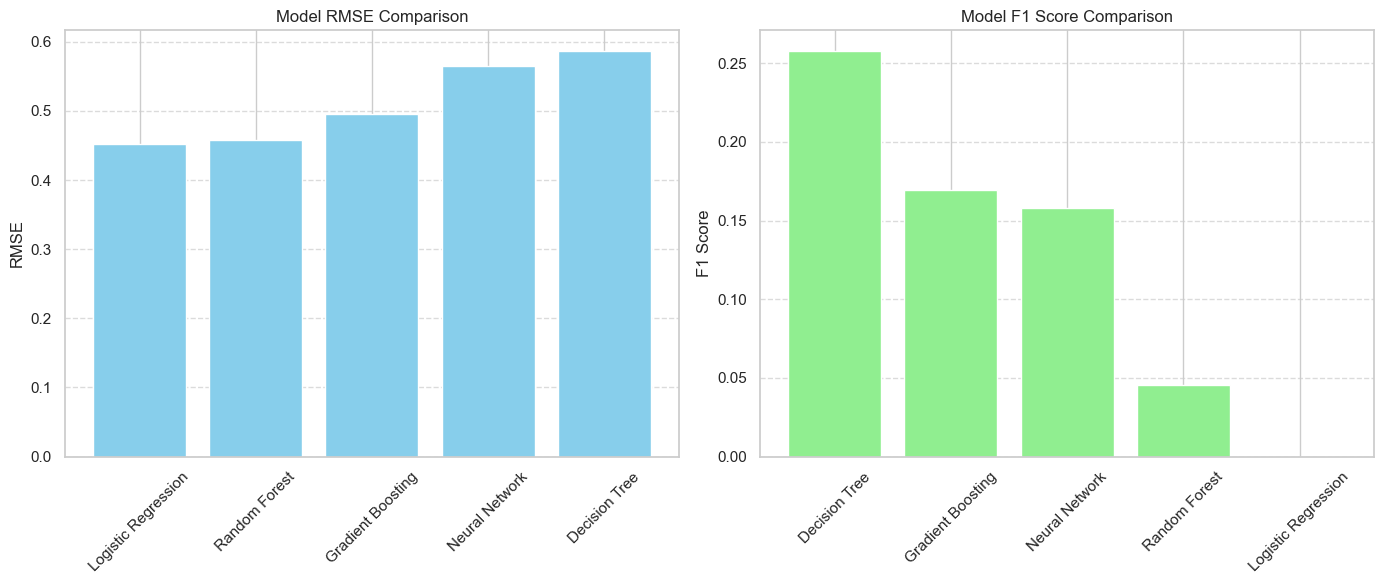

In [51]:
# Re-import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt


# Sort for better visualisation
metrics_df_sorted_rmse = metrics_df.sort_values(by="RMSE")
metrics_df_sorted_f1 = metrics_df.sort_values(by="F1 Score", ascending=False)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# RMSE Plot
axes[0].bar(metrics_df_sorted_rmse["Model"], metrics_df_sorted_rmse["RMSE"], color='skyblue')
axes[0].set_title("Model RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(metrics_df_sorted_rmse["Model"], rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# F1 Score Plot
axes[1].bar(metrics_df_sorted_f1["Model"], metrics_df_sorted_f1["F1 Score"], color='lightgreen')
axes[1].set_title("Model F1 Score Comparison")
axes[1].set_ylabel("F1 Score")
axes[1].set_xticklabels(metrics_df_sorted_f1["Model"], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


ROC AUC CURVE

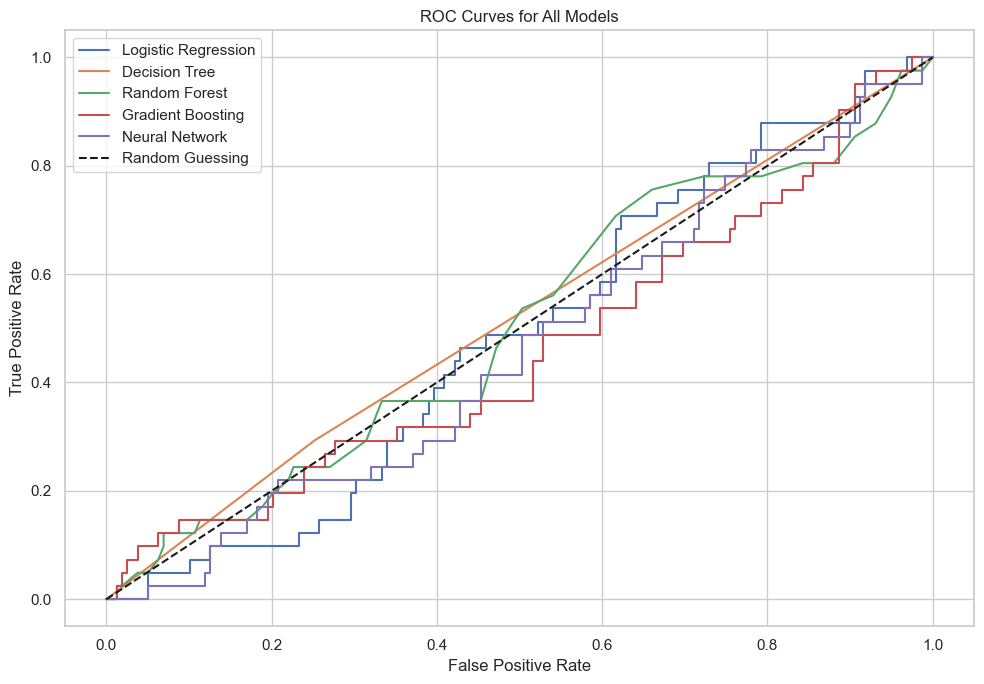

In [52]:
#

# Plot ROC curves
plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name}")

# Random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MODEL DEPLOYMENT

In [53]:
import joblib

best_model = models["Decision Tree"]        #SAVE MODEl
joblib.dump(best_model, "decision_tree_model.pkl")


['decision_tree_model.pkl']

In [ ]:
# print(X.columns.tolist())



,CustomerID,ChurnStatus,Age,total_transactions,total_spent,avg_spend,unique_categories,LastLoginDate,LoginFrequency,unresolved_issues,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_High,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,0,62,1,416.50,416.500000,1,2023-10-21,34,0.0,...,0,0,1,0,0,1,0,1,0,0
1,2,1,65,7,1547.42,221.060000,4,2023-12-05,5,0.0,...,0,1,0,0,0,1,0,0,0,1
2,3,0,18,6,1702.98,283.830000,4,2023-11-15,3,0.0,...,0,0,1,0,0,1,0,0,0,1
3,4,0,21,5,917.29,183.458000,4,2023-08-25,2,1.0,...,0,0,0,1,0,1,0,0,0,1
4,5,0,21,8,2001.49,250.186250,3,2023-10-27,41,0.0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,54,1,227.25,227.250000,1,2023-01-29,38,0.0,...,0,0,1,0,0,1,0,1,0,0
996,997,0,19,2,419.82,209.910000,2,2023-04-01,5,0.0,...,0,0,0,1,1,0,0,1,0,0
997,998,0,47,1,252.15,252.150000,1,2023-07-10,47,0.0,...,0,1,0,0,0,1,0,0,0,1
998,999,0,23,9,2393.26,265.917778,4,2023-01-08,23,0.0,...,0,0,0,1,1,0,0,0,0,1
